数据集和数据加载器 — PyTorch 教程 2.2.0+cu121 文档


[数据集和数据加载器 — PyTorch 教程 2.2.0+cu121 文档](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)



# 数据集和数据加载器

用于处理数据样本的代码可能会变得混乱且难以维护；理想情况下，我们希望数据集代码与模型训练代码分离，以获得更好的可读性和模块化性。PyTorch 提供了两个数据原语：`torch.utils.data.DataLoader`和`torch.utils.data.Dataset` ，允许您使用预加载的数据集以及您自己的数据。 `Dataset`存储样本及其相应的标签，并`DataLoader`围绕 `Dataset`进行迭代，以方便访问样本。

PyTorch 域库提供了许多预加载的数据集（例如 FashionMNIST）。这些数据集是`torch.utils.data.Dataset`的子类。并且，对于特定数据，实现特定的函数。它们可用于对您的模型进行原型设计和基准测试。您可以在这里找到它们：[图像数据集](https://pytorch.org/vision/stable/datasets.html)、 [文本数据集](https://pytorch.org/text/stable/datasets.html)和 [音频数据集](https://pytorch.org/audio/stable/datasets.html)

## 加载数据集

以下是如何从 TorchVision 加载[Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/)数据集的示例。Fashion-MNIST 是 Zaland论文文章的图像数据集。这个数据集由 60,000 个训练样本和 10,000 个测试样本组成。每个样本包含一个 28×28 灰度图像和来自 10 个类别之一的关联标签。

我们使用以下参数，来加载[FashionMNIST 数据集](https://pytorch.org/vision/stable/datasets.html#fashinistom)


  - `root` 是存储训练/测试数据的路径，

- `train` 指定训练或测试数据集，

- `download=True` 如果`root` 上没有数据，则从 Internet 下载数据。

- `transform`并`target_transform`指定特征和标签转换。

In [9]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

# 迭代和可视化数据集

我们可以像列表一样手动索引`Datasets`：`training_data[index]`。我们用`matplotlib`来可视化训练数据中的一些样本。

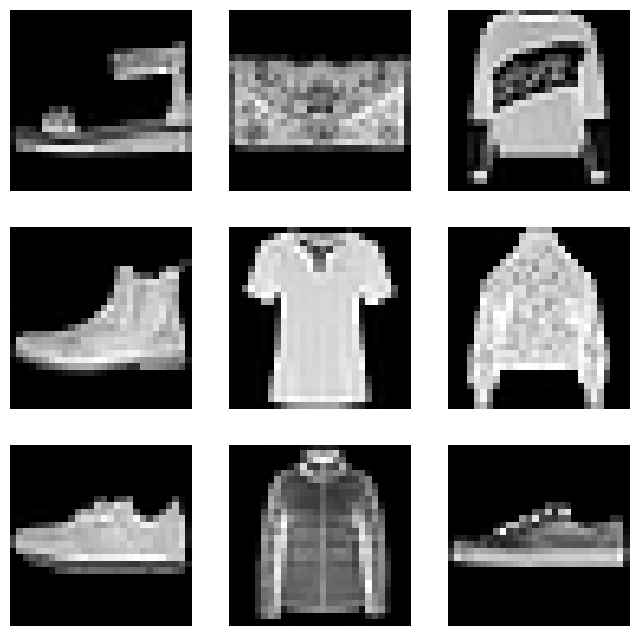

In [10]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize = (8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size = (1, )).item()
    img, idx = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap = "gray")
plt.show()

# 为您的文件创建自定义数据集

自定义 Dataset 类必须实现三个函数：`__init__`、`__len__`和`__getitem`__。看看这个实现：FashionMNIST 图像存储在目录`img_dir`中，它们的标签单独存储在CSV 文件`annotations_file`中。

In [11]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform = None, target_tansform = None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transfrom(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


## \__init__

`__init__` 函数在实例化 Dataset 对象时运行一次。我们初始化包含图像、注释文件和两种转换的目录（下一节将更详细地介绍）。

In [4]:
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9

SyntaxError: invalid syntax (808860634.py, line 3)

In [12]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

## \__len__

`__len__` 函数返回数据集中的样本数。

例子：

In [13]:
def __len__(self):
    return len(self.img_labels)

## \__getitem__

`__getitem__` 函数从数据集加载并返回给定索引`idx`的的样本。基于索引，它识别图像在磁盘上的位置，使用`read_image` 将其转换为张量，从 `self.img_labels`中的 csv 数据中检索相应的标签，调用它们的转换函数（如果适用），并以元组方式返回张量图像和相应的标签。

In [14]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

# 使用 DataLoaders 准备数据以进行训练

`Dataset`检索我们的数据集的特征并一次标记一个样本。在训练模型时，我们通常希望以 “minibatches”方式传递样本，在每个epcoch重新整理数据以减少模型过度拟合，并使用 Python的`multiprocessing`来加速数据检索。

`DataLoader`是一个可迭代对象，它通过一个简单的 API 为我们抽象了这种复杂性。

In [16]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

# 遍历 DataLoader

我们已将该数据集加载到 `DataLoader` 中，并且可以根据需要迭代数据集。下面的每次迭代都会返回一批`train_features`和`train_labels`（`batch_size=64`分别包含特征和标签）。因为我们指定了`shuffle=True`，所以在迭代所有批次后，数据将被打乱（为了更细粒度地控制数据加载顺序，请查看[Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)）。

Feature batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])
Label: 7


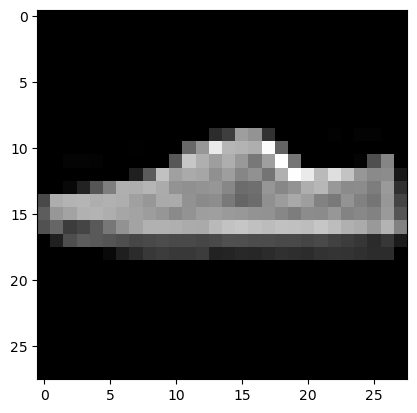

In [22]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Label batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(f"Label: {label}")
plt.imshow(img, cmap = "gray")
plt.show()

# 进一步阅读

- [torch.utils.data API](https://pytorch.org/docs/stable/data.html)